# Import packages

In [1]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import ot
import time
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid
from utils import *
import numpy as np

# Print the version of numpy
print(np.__version__)



1.26.4


In [2]:
import sys
sys.path.append("../")


from lib.linear_gromov import LGW_dist,LPGW_embedding,LPGW_dist,LGW_dist,LGW_embedding
from lib.opt import opt_lp,emd_lp
from lib.gromov import gromov_wasserstein, cost_matrix_d, tensor_dot_param, tensor_dot_func, gwgrad_partial1, partial_gromov_wasserstein, partial_gromov_ver1
from lib.gromov import GW_dist,MPGW_dist, PGW_dist_with_penalty

from lib.gromov_barycenter import gw_barycenters,pgw_barycenters
from lib.linear_gromov import LGW_dist,LPGW_embedding,LPGW_dist,LGW_dist,LGW_embedding,lgw_procedure,lpgw_procedure
from lib.opt import opt_lp,emd_lp
from lib.gromov import gromov_wasserstein, cost_matrix_d, tensor_dot_param, tensor_dot_func, gwgrad_partial1, partial_gromov_wasserstein, partial_gromov_ver1
from lib.gromov import GW_dist,MPGW_dist, PGW_dist_with_penalty


In [3]:
import torch
from lib.unbalanced_gromov_wasserstein.unbalancedgw.vanilla_ugw_solver import exp_ugw_sinkhorn
from lib.unbalanced_gromov_wasserstein.unbalancedgw._vanilla_utils import ugw_cost

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load Shapes

In [4]:
posns = np.load("bone_star_data.npz")
posns = list(posns.values())

alpha = 1/50.
heights = [alpha * np.ones(x.shape[0]) for x in posns]

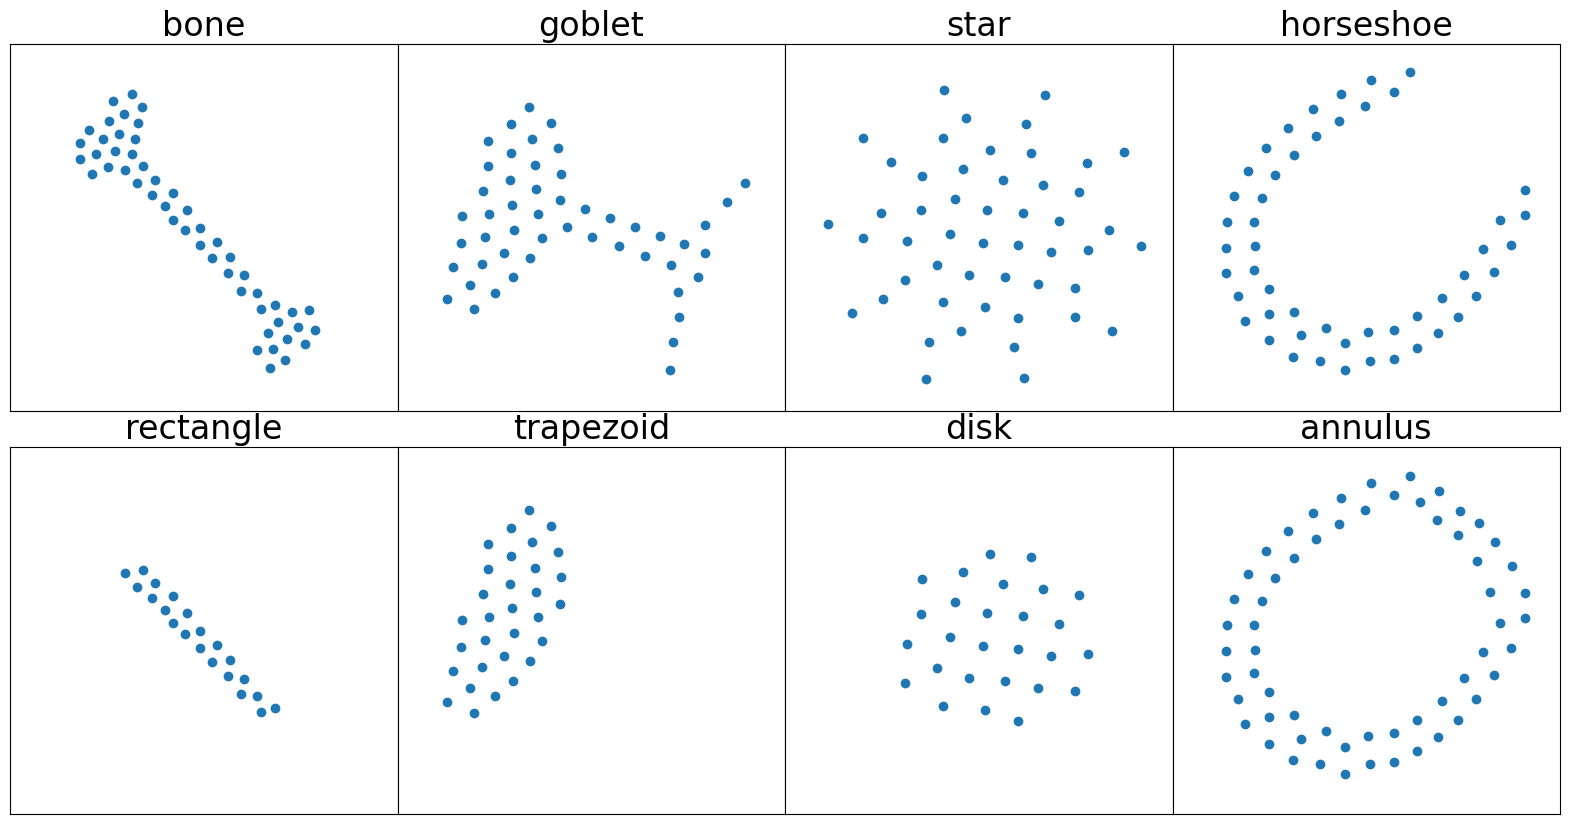

In [5]:
fig, ax = plt.subplots(2, 4, figsize=(20,10))

# Remove padding between subplots
plt.subplots_adjust(wspace=0, hspace=0.1)

indices = [0, 20, 41, 60]
titles = ["bone","goblet", "star", "horseshoe", "rectangle", "trapezoid", "disk", "annulus"]

for i in range(8):
    idx = indices[i % 4] + (80 if i >= 4 else 0)
    ax[i//4, i%4].scatter(posns[idx][:,0], posns[idx][:,1])
    ax[i//4, i%4].set_xlim(-.6, .6)
    ax[i//4, i%4].set_ylim(-.6, .6)
    ax[i//4, i%4].set_title(titles[i], fontsize=24)

    # Turn off x,y labels
    ax[i//4, i%4].set_xticks([])
    ax[i//4, i%4].set_yticks([])
    # ax[i//4, i%4].set_title(i * 20)

plt.savefig("results/bone_star_data.png", dpi=300, bbox_inches='tight')
plt.savefig("results/bone_star_data.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [6]:
posns = posns[:20] + posns[80:100] + posns[20:40] + posns[100:120] + posns[40:60] + posns[120:140] + posns[60:80] + posns[140:160]
heights = heights[:20] + heights[80:100] + heights[20:40] + heights[100:120] + heights[40:60] + heights[120:140] + heights[60:80] + heights[140:160]
len(posns)

160

In [7]:
numItem = 20
classes = np.arange(8)
N = len(classes)*20

In [8]:
Ms = []
LAMBDA_MAX = 0

for i in range(len(posns)):
    Ms.append(np.sqrt((cost_matrix_d(posns[i], posns[i]))))
    LAMBDA_MAX = max(LAMBDA_MAX, Ms[i].max() ** 2)
print('Lambda_max',LAMBDA_MAX)

Lambda_max 1.3076553798204047


# GW

In [14]:
st = time.time()        
gw = np.zeros((N,N))

for i in range(N):
    M1 = Ms[i].copy()
    height1 = heights[i]
    
    for j in range(i+1, N):
        print('i is %i, j is %i'%(i,j),end='\r')
        M2 = Ms[j].copy()
        
        height2 = heights[j]
        gamma = gromov_wasserstein(M1, M2, height1/height1.sum(), height2/height2.sum(), G0=None,thres=1, numItermax=100*N, tol=1e-5,log=False, verbose=False,line_search=False)
        gw[i, j] = GW_dist(M1, M2, gamma)
gw = np.sqrt(gw)
gw += gw.T
et = time.time()
print("GW computation: " + str(np.round(et-st,2)) + "s")
np.savez('results/gw',dist=gw,time=et-st)

GW computation: 6616.31s


In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(gw, cmap='jet')
plt.colorbar()
plt.show()

In [15]:
st = time.time()        
pgw = np.zeros((N,N))
alpha=0.2
for beta in [0.2,0.3,0.5]:
    print('beta is',beta)
    Lambda = beta * LAMBDA_MAX
    
    for i in range(N):
        M1 = Ms[i]
        height1 = heights[i]
    
        for j in range(i+1, N):
            print('i is %i, j is %i'%(i,j),end='\r')
            M2 = Ms[j]
            height2 = heights[j]
    
            
            gamma = partial_gromov_ver1(M1, M2, height1, height2, G0=None, Lambda=Lambda, thres=1, numItermax=100*N, tol=1e-5,log=False, verbose=False,line_search=False)
    
            pgw_trans,pgw_penalty=PGW_dist_with_penalty(M1,M2,gamma, height1, height2, Lambda)
            pgw[i, j]=pgw_trans+pgw_penalty 
    
    pgw[pgw < 0] = 0
    pgw += pgw.T
    pgw = np.sqrt(pgw)
    
    et = time.time()
    np.savez('results/pgw_%0.3f'%beta,dist=pgw,time=et-st)
    print("PGW computation: " + str(np.round(et-st,2)) + "s")

beta is 0.2
PGW computation: 6360.47s
beta is 0.3
PGW computation: 12819.15s
beta is 0.5
PGW computation: 18901.78s


In [17]:
# reference 
idx_bary = [c*numItem for c in range(len(classes))] #indices of shapes for barycenter computation
n_bary = len(idx_bary)
k_bary = 40
ps =np.array(heights,dtype='object')[idx_bary] 
ps = [p/p.sum() for p in ps]
    
st = time.time()   
height_ref = ot.unif(k_bary)
M_ref = ot.gromov.gromov_barycenters(k_bary, Cs = np.array(Ms,dtype='object')[idx_bary],
                                           ps = ps, p = height_ref, lambdas = ot.unif(n_bary), loss_fun='square_loss',
                                           max_iter=100, tol=1e-12,random_state=2746,log=False)
et = time.time()

print("Barycenter computation: " + str(np.round(et-st,2)) + "s")

Barycenter computation: 775.6s


In [ ]:
#embedding and plot
mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
embedding = mds.fit_transform(M_ref)

scatter_atomic(embedding, height_ref, n_plots_per_col=1, xmarkers=False, axis_off=True, margin_fac=0.05)

# PGW

In [18]:
height_ref=np.ones(40)/40
lgw, wall_time=lgw_procedure(M_ref,height_ref,posns,Ms,heights,mode = "euclidean")
print("LGW computation: " + str(np.round(wall_time,2)) + "s")
np.savez('results/lgw',dist=pgw,time=wall_time)
print("LGW computation: " + str(np.round(et-st,2)) + "s")

for beta in [0.2,0.3,0.5]:
    Lambda = beta * LAMBDA_MAX
    lpgw_trans,lpgw_penalty, wall_time,(embeddings,Bps)=lpgw_procedure(M_ref,height_ref,posns,Ms,heights,Lambda=Lambda,mode = "euclidean")
    print("LPGW computation: " + str(np.round(wall_time,2)) + "s")
    lpgw=np.sqrt(lpgw_trans+lpgw_penalty)
    np.savez('results/lpgw%0.3f'%beta,dist=lpgw,time=wall_time)


SyntaxError: invalid syntax (3750946153.py, line 4)

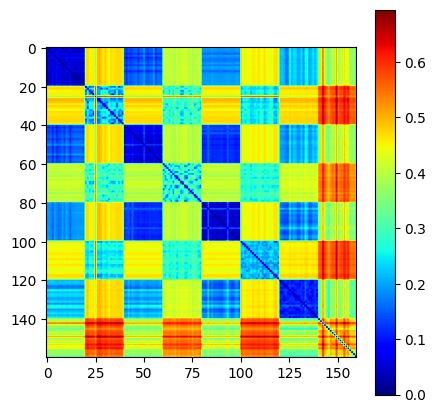

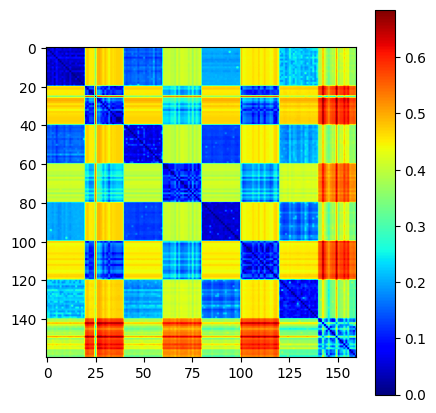

NameError: name 'svm_cross_val' is not defined

In [21]:
plt.figure(figsize=(5,5))
plt.imshow(lpgw, cmap='jet')
plt.colorbar()
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(pgw, cmap='jet')
plt.colorbar()
plt.show()

accs, mean_acc = svm_cross_val(gw/np.max(gw))
print("Mean accuracy for GW: ", mean_acc)

accs, mean_acc = svm_cross_val(pgw/np.max(pgw))
print("Mean accuracy for PGW: ", mean_acc)

accs, mean_acc = svm_cross_val(lgw/np.max(lgw))
print("Mean accuracy for LGW: ", mean_acc)

accs, mean_acc = svm_cross_val(lpgw/np.max(lpgw))
print("Mean accuracy for LPGW: ", mean_acc)


# Mass Constrained PGW

In [68]:
st = time.time()        
mpgw = np.zeros((N,N))

for i in range(N):
    M1 = Ms[i]
    height1 = heights[i].copy()

    for j in range(i+1, N):
        M2 = Ms[j]
        height2 = heights[j].copy()

        mass = min(height1.sum(), height2.sum())
        gamma = partial_gromov_wasserstein(M1, M2, height1, height2, G0=None, m=mass, thres=1, numItermax=100*N, tol=1e-5,log=False, verbose=False,line_search=False)
        mpgw[i, j]=MPGW_dist(M1,M2,gamma)

mpgw[mpgw < 0] = 0
mpgw = np.sqrt(mpgw)
mpgw += mpgw.T
et = time.time()
print("MPGW computation: " + str(np.round(et-st,2)) + "s")

KeyboardInterrupt: 

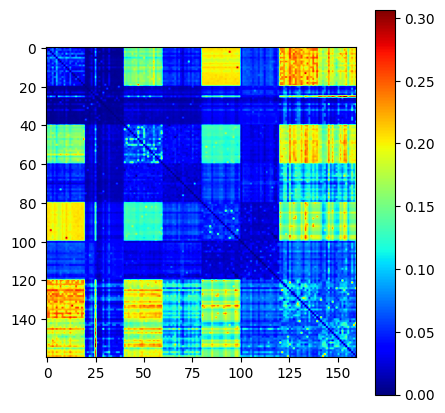

In [142]:
plt.figure(figsize=(5,5))
plt.imshow(mpgw, cmap='jet')
plt.colorbar()
plt.show()

# Unbalanced GW

In [143]:
st = time.time()        
ugw = np.zeros((N,N))

for i in tqdm(range(N)):
    shape_i = posns[i]
    M1 = Ms[i]
    M1 = torch.from_numpy(M1).to(device)
    height1 = heights[i]
    height1 = torch.from_numpy(height1).to(device)

    for j in range(i, N):
        shape_j = posns[j]
        M2 = Ms[j]
        M2 = torch.from_numpy(M2).to(device)
        height2 = heights[j]
        height2 = torch.from_numpy(height2).to(device)

        eps = 1e-1
        rho = rho2 = 1

        pi, gamma = exp_ugw_sinkhorn(height1, M1, height2, M2, init=None, 
                                     eps=eps,
                                     rho=rho, 
                                     rho2=rho2,
                                     nits_plan=1000, tol_plan=1e-5, nits_sinkhorn=1000, 
                                     tol_sinkhorn=1e-5, two_outputs=True)
        
        # print(gamma.max())

        cost = ugw_cost(pi, gamma, height1, M1, height2, M2, eps=eps, rho=rho, rho2=rho2)
        ugw[i, j] = cost


    

ugw[ugw < 0] = 0
ugw = np.sqrt(ugw)
ugw += ugw.T - np.diag(ugw.diagonal())
et = time.time()
print("ugw computation: " + str(np.round(et-st,2)) + "s")

100%|█████████████████████████████████████████| 160/160 [03:28<00:00,  1.30s/it]

ugw computation: 208.31s


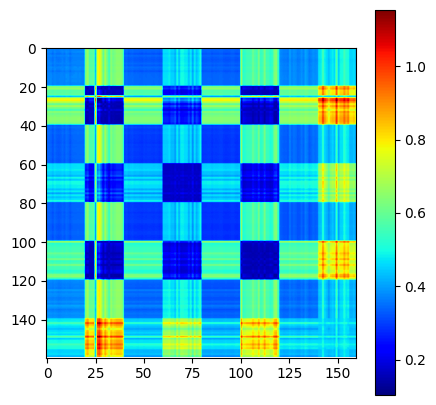

In [144]:
plt.figure(figsize=(5,5))
plt.imshow(ugw, cmap='jet')
plt.colorbar()
plt.show()

# Save/Load Dist Matrices

In [39]:
# Save all distance matrices
save = True
if save:
    np.savez("result/bone_star_dist_res.npz", gw=gw, pgw=pgw, lgw=lgw, lpgw=lpgw)

In [40]:
load = True
if load:
    dists = np.load("result/bone_star_dist_res.npz")
    gw, pgw, lgw, lpgw = dists.values()
    numItem = 20
    classes = np.arange(8)
    N = len(classes)*20

# Perform 10-fold cross validation

In [24]:
X = np.arange(N)                                           # dataset
y = np.concatenate([np.ones(numItem)*i for i in classes])  # labels

In [25]:
numItem

20

In [26]:
# Adapted from Beier et al: https://github.com/Gorgotha/LGW
def svm_cross_val(dist, gamma=10, k=10):
    dist_sq=dist
    k_folds = sklearn.model_selection.StratifiedKFold(n_splits = 10)
    k_folds.get_n_splits(X,y)

    dist = dist / dist.max()

    accs = []

    for train_index, test_index in k_folds.split(X, y):
        
        # get train and test data for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # set up SVM
        kernel_train = np.exp(-gamma * dist[X_train].T[X_train].T)
        svc = svm.SVC(kernel="precomputed")
        
        # fit SVM
        clf = svc.fit(kernel_train, y_train)

        kernel_test = np.exp(-gamma * dist_sq[X_test].T[X_train].T)
        acc = clf.score(kernel_test, y_test)
        accs.append(acc)

    return accs, np.mean(accs)

In [1]:
accs, mean_acc = svm_cross_val(gw/np.max(gw))
print("Mean accuracy for GW: ", mean_acc)

accs, mean_acc = svm_cross_val(pgw/np.max(pgw))
print("Mean accuracy for PGW: ", mean_acc)

# accs, mean_acc = svm_cross_val(lgw/np.max(lgw))
# print("Mean accuracy for LGW: ", mean_acc)

accs, mean_acc = svm_cross_val(lpgw/np.max(lpgw))
print("Mean accuracy for LPGW: ", mean_acc)



NameError: name 'svm_cross_val' is not defined

# Plot

In [61]:
def plot_dists(dists, labels):
    fig = plt.figure(figsize=(len(dists) * 6, 6))
    min_val, max_val = 0, 1

    grid = ImageGrid(fig, 111,          
                     nrows_ncols=(1,len(dists)),
                     axes_pad=0.15,
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="single",
                     cbar_size="7%",
                     cbar_pad=0.15,
                     )
    
    shape_labels = ["bone","rectangle", "goblet", "trapezoid", "star","disk", "horseshoe", "annulus"]
    x = [10,30,50,70,90,110,130,150]
    plt.setp(grid, xticks=x, xticklabels=shape_labels, yticks=x, yticklabels=shape_labels)
    
    for data, ax, title in zip(dists, grid, labels):
        data = data/np.max(data)
        im = ax.imshow(data, vmin = min_val, vmax = max_val,cmap = "jet")

        ax.set_title(title, fontsize=24)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=18)
        plt.setp(ax.get_yticklabels(), fontsize=18)
    
    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)

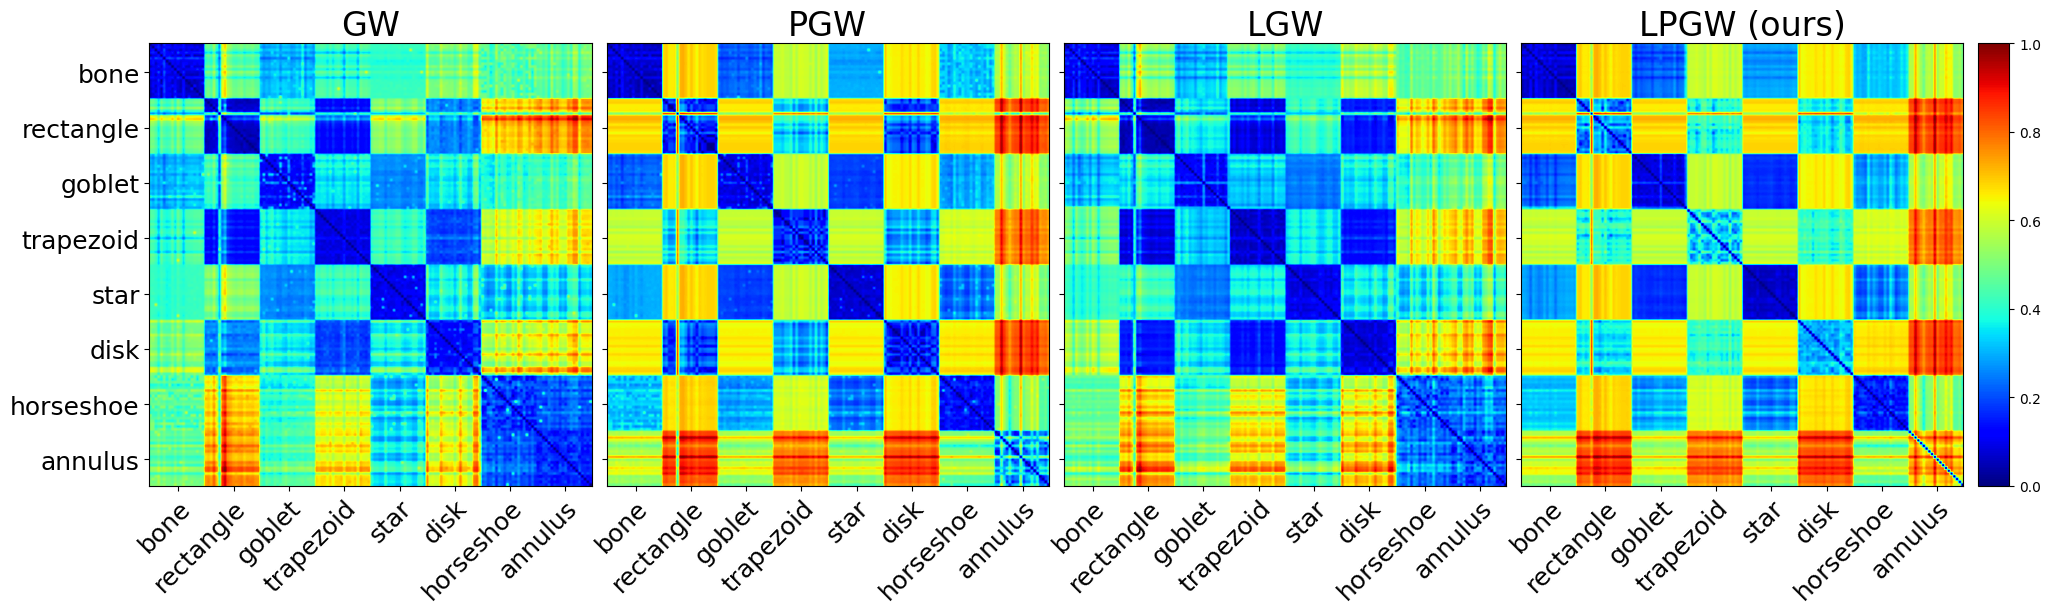

In [62]:
plot_dists([gw, pgw, lgw, lpgw], [f"GW", f"PGW", f"LGW", f"LPGW (ours)"])
plt.savefig("result/bone_star_dists.png", bbox_inches='tight', dpi=300)
plt.savefig("result/bone_star_dists.pdf", bbox_inches='tight', dpi=300)

# Confusion Matrix

In [55]:
# Adapted from Beier et al: https://github.com/Gorgotha/LGW
def conf_mat(dists, X, y, n_its = 10000):
    N = len(y)
    classes = np.array(np.unique(y),dtype=int)
    x_pred = []
    x_true = []
    for j in range(n_its):
        l = []
        for i in classes:
            l.append([np.random.choice(X[y == i]),i])
        l = np.array(l)
        for i in range(N):
            tmp1 = np.argmin(dists[i][l[:,0]])
            x_true.append(y[i])
            x_pred.append(tmp1)
    
    conf = sklearn.metrics.confusion_matrix(x_true, x_pred)
    return conf

def plot_conf(confs, labels):
    fig = plt.figure(figsize=(len(confs) * 6, 6))
    min_val, max_val = 0, 1

    grid = ImageGrid(fig, 111,          
                     nrows_ncols=(1,len(confs)),
                     axes_pad=0.15,
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="single",
                     cbar_size="7%",
                     cbar_pad=0.15,
                     )
    
    shape_labels = ["bone","rectangle", "goblet", "trapezoid", "star","disk", "horseshoe", "annulus"]
    x = list(range(len(shape_labels)))
    plt.setp(grid, xticks=x, xticklabels=shape_labels, yticks=x, yticklabels=shape_labels)
    
    for data, ax, title in zip(confs, grid, labels):
        data = data/np.max(data)
        im = ax.imshow(data, vmin = min_val, vmax = max_val,cmap = "jet")

        ax.set_title(title, fontsize=24)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=18)
        plt.setp(ax.get_yticklabels(), fontsize=18)
    
    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)

In [57]:
accs, mean_acc = svm_cross_val(gw/np.max(gw))
print("Mean accuracy for GW: ", mean_acc)

accs, mean_acc = svm_cross_val(pgw/np.max(pgw))
print("Mean accuracy for PGW: ", mean_acc)

accs, mean_acc = svm_cross_val(lgw/np.max(lgw))
print("Mean accuracy for LGW: ", mean_acc)

accs, mean_acc = svm_cross_val(lpgw/np.max(lpgw))
print("Mean accuracy for LPGW: ", mean_acc)

#compute confusion matrices
conf_gw = conf_mat(gw, X=X, y=y)
conf_pgw = conf_mat(pgw, X=X, y=y)
conf_lgw = conf_mat(lgw, X=X, y=y)
conf_lpgw = conf_mat(lpgw, X=X, y=y)

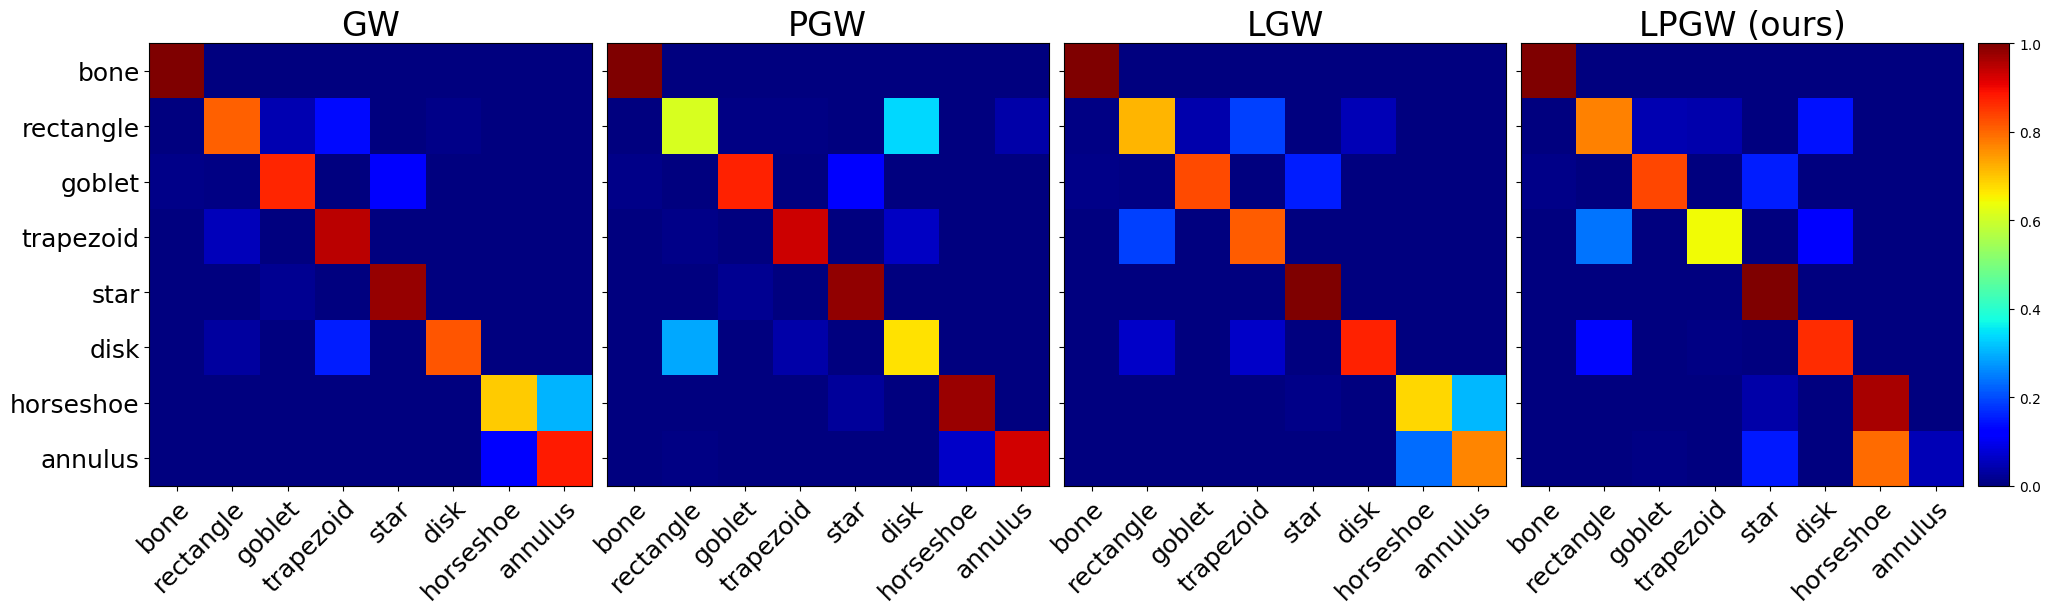

In [58]:
plot_conf([conf_gw, conf_pgw, conf_lgw, conf_lpgw], labels=["GW", "PGW", "LGW", "LPGW (ours)"])
plt.savefig("result/bone_star_conf.png", bbox_inches='tight', dpi=300)
plt.savefig("result/bone_star_conf.pdf", bbox_inches='tight', dpi=300)